In [1]:
#pip install matplotlib
#pip install kaggle

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import zipfile
import json
import os
import time

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

base_dir = "/home/fsuser/" # install git repo in this directory
repo_dir = base_dir + "de-identification/"

Random Seed:  999


In [4]:
################# Download dataset on Fluidstack ###############

#Setting up and connecting to Kaggle API
kaggle_apikey = {"username":"jamesdavey","key":"a8975caa44cfa08d6f2164f2d5977b6e"}

kaggle_dir = base_dir + '.kaggle'
print("base_dir:", base_dir)
print("kaggle_dir:", kaggle_dir)
if not os.path.exists(kaggle_dir): 
    print("making folder: ", kaggle_dir)
    os.mkdir(kaggle_dir)

with open(kaggle_dir+'/kaggle.json', 'w') as f:
    json.dump(kaggle_apikey, f)

! chmod 600 ~/.kaggle/kaggle.json

# open file at ~/.kaggle/kaggle.json and print it
with open(kaggle_dir+'/kaggle.json', 'r') as f:
    print('~/.kaggle/kaggle.json ==', f.read())

data_path = repo_dir+"downloaded-data/"

base_dir: /home/fsuser/
kaggle_dir: /home/fsuser/.kaggle
~/.kaggle/kaggle.json == {"username": "jamesdavey", "key": "a8975caa44cfa08d6f2164f2d5977b6e"}


In [5]:
if not os.path.exists(data_path): 
    print("Creating folder: ", data_path)
    os.mkdir(data_path)

!kaggle config set -n path -v {data_path}

! kaggle datasets download jessicali9530/celeba-dataset --force

zip_path = data_path+"datasets/jessicali9530/celeba-dataset/celeba-dataset.zip"
with zipfile.ZipFile(zip_path,"r") as zip_ref:
    zip_ref.extractall(data_path)

- path is now set to: /home/fsuser/de-identification/downloaded-data/
100%|█████████████████████████████████████▊| 1.32G/1.33G [00:19<00:00, 78.8MB/s]
100%|██████████████████████████████████████| 1.33G/1.33G [00:20<00:00, 70.8MB/s]


In [5]:
# Root directory for dataset
dataroot = data_path+ 'img_align_celeba/'

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64 # use 128 but only generates central 64x64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

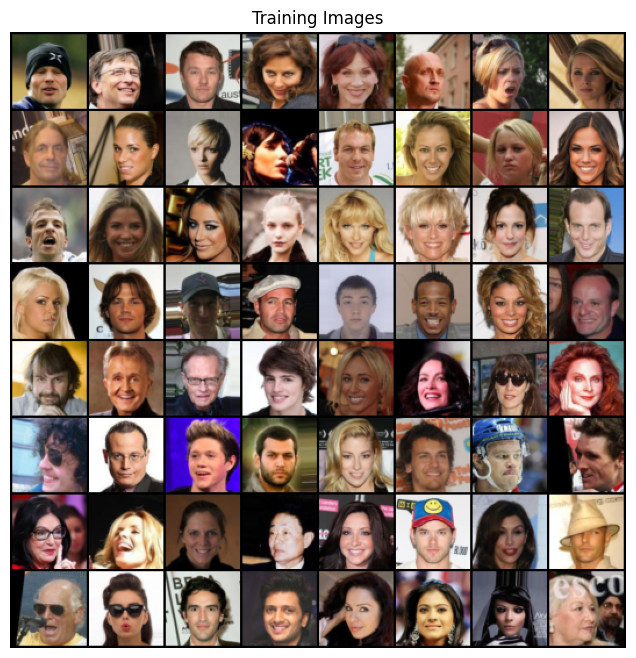

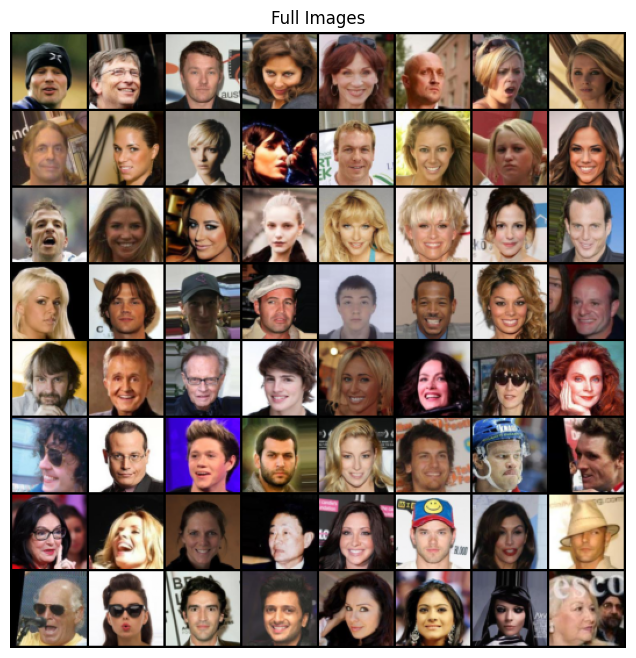

In [6]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Full Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [7]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [9]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [10]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [11]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [12]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [13]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
t_start = time.time()
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 200 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f Time : %.2fs'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, time.time() - t_start))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/10][0/1583]	Loss_D: 1.5436	Loss_G: 6.9124	D(x): 0.7940	D(G(z)): 0.6395 / 0.0021 Time : 1.57s
[0/10][200/1583]	Loss_D: 0.8117	Loss_G: 7.9526	D(x): 0.9778	D(G(z)): 0.4562 / 0.0008 Time : 15.27s
[0/10][400/1583]	Loss_D: 0.2916	Loss_G: 4.8184	D(x): 0.8213	D(G(z)): 0.0568 / 0.0165 Time : 29.04s
[0/10][600/1583]	Loss_D: 1.0597	Loss_G: 5.8185	D(x): 0.5136	D(G(z)): 0.0052 / 0.0078 Time : 42.85s
[0/10][800/1583]	Loss_D: 0.2062	Loss_G: 4.4924	D(x): 0.9279	D(G(z)): 0.1076 / 0.0202 Time : 56.58s
[0/10][1000/1583]	Loss_D: 0.3307	Loss_G: 4.9029	D(x): 0.9497	D(G(z)): 0.1978 / 0.0172 Time : 70.21s
[0/10][1200/1583]	Loss_D: 0.3517	Loss_G: 4.1966	D(x): 0.8318	D(G(z)): 0.1076 / 0.0301 Time : 83.94s
[0/10][1400/1583]	Loss_D: 0.2855	Loss_G: 3.9128	D(x): 0.9166	D(G(z)): 0.1526 / 0.0425 Time : 97.66s
[1/10][0/1583]	Loss_D: 0.3584	Loss_G: 4.3510	D(x): 0.9316	D(G(z)): 0.2202 / 0.0220 Time : 110.59s
[1/10][200/1583]	Loss_D: 0.3751	Loss_G: 3.6736	D(x): 0.8920	D(G(z)): 0.1823 / 0.0419

KeyboardInterrupt: 

In [16]:
list(netG.parameters())[0][0][0]

tensor([[-0.0011,  0.0205,  0.0324,  0.0580],
        [-0.0363, -0.0055,  0.0035,  0.0107],
        [ 0.0536,  0.0123,  0.0151, -0.0030],
        [-0.0125, -0.0096, -0.0120, -0.0263]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [17]:
list(netD.parameters())[0][0][0]

tensor([[ 0.0307, -0.0113,  0.0036, -0.0105],
        [-0.0175, -0.0448, -0.0304,  0.0176],
        [ 0.0068, -0.0258,  0.0547,  0.0032],
        [ 0.0053, -0.0303,  0.0128,  0.0356]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [18]:
models_dir = repo_dir + "pretrained-models/"
version = 'original-3-epochs'
torch.save(netG.state_dict(), models_dir + f"DCGAN-{version}-netG.pth")
torch.save(netD.state_dict(), models_dir + f"DCGAN-{version}-netD.pth")

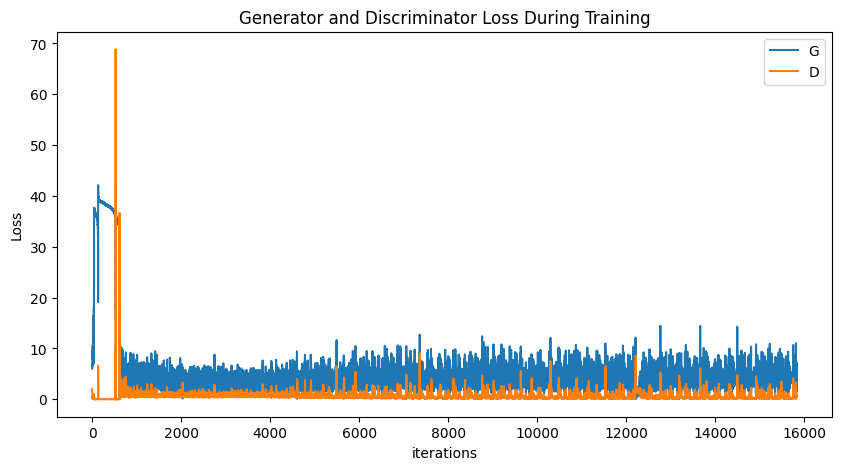

In [27]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# fig = plt.figure(figsize=(8,8))
# plt.axis("off")
# ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# HTML(ani.to_jshtml())

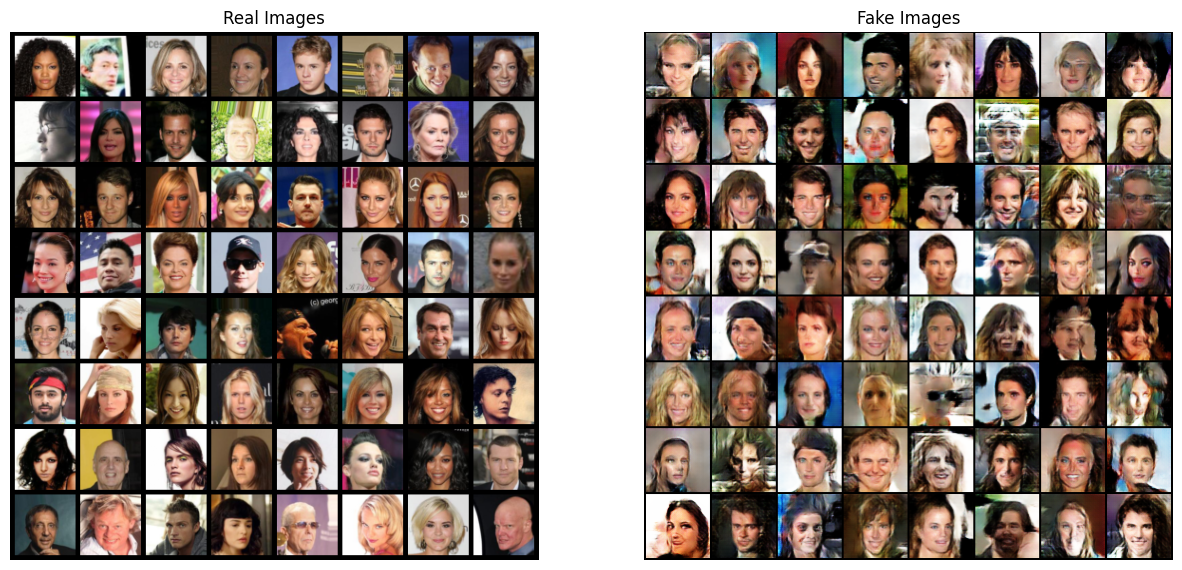

In [15]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [39]:
#load models
netG_loaded = Generator(ngpu).to(device)
netG_loaded.load_state_dict(torch.load(models_dir + f"DCGAN-{version}-netG.pth"))
netG_loaded.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [ ]:
list(netG_loaded.parameters())[0][0][0]

In [ ]:
list(netG.parameters())[0][0][0]

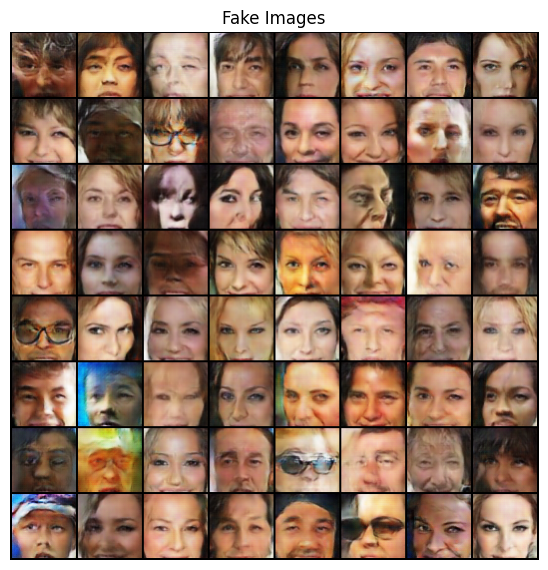

In [38]:
with torch.no_grad():
    fake = netG_loaded(fixed_noise).detach().cpu()
grid = vutils.make_grid(fake, padding=2, normalize=True)

# Plot the fake images from the last epoch
plt.figure(figsize=(15,15))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(grid,(1,2,0)))
plt.show()

In [ ]:
# netD = Discriminator(ngpu).to(device)
# netD.load_state_dict(torch.load(models_dir + f"DCGAN-{version}-netD.pth"))

In [ ]:

netG.eval()
# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

In [ ]:
list(netG.parameters())[0][0][0]

In [ ]:
 with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
grid = vutils.make_grid(fake, padding=2, normalize=True)

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(grid,(1,2,0)))
plt.show()

In [ ]:
noise = torch.randn(b_size, nz, 1, 1, device=device)
    

fake = netG(noise).detach().cpu()

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True),(1,2,0)))
plt.show()

In [ ]:
import torch
import torch.nn as nn

#Code to add to make it match "Semanti Image Inpainting with Perceptual and Contextual Losses"

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
#1 is part of image to keep, 0 is part to generate
mask = torch.ones((64, 64), device=device)
mask[16:48, 16:48] = 0.0
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.
# import matplotlib.pyplot as plt
# plt.imshow(mask.numpy(), cmap="gray")

In [ ]:
# contextual_loss = nn.functional.l1_loss(mask*G, mask*images)
# perceptual_loss = g_loss
# complete_loss = perceptual_loss + lam*contextual_loss

In [ ]:
# for idx in xrange(0, batch_idxs):
#     batch_images = ...
#     batch_mask = np.resize(mask, [self.batch_size] + self.image_shape)
#     zhats = np.random.uniform(-1, 1, size=(self.batch_size, self.z_dim))

#     v = 0
#     for i in xrange(config.nIter):
#         fd = {
#             self.z: zhats,
#             self.mask: batch_mask,
#             self.images: batch_images,
#         }
#         run = [self.complete_loss, self.grad_complete_loss, self.G]
#         loss, g, G_imgs = self.sess.run(run, feed_dict=fd)

#         v_prev = np.copy(v)
#         v = config.momentum*v - config.lr*g[0]
#         zhats += -config.momentum * v_prev + (1+config.momentum)*v
#         zhats = np.clip(zhats, -1, 1)